In [59]:
import tensorflow as tf
import numpy as np

In [60]:
from tensorflow.keras.layers import Conv1D, MaxPool1D, LSTM, Dense, MultiHeadAttention, LayerNormalization, Flatten, Dropout

In [61]:
class ResNetToTransformer(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.resnet = ResNet1D()
        self.transformer_layer_1 = TransformerMini()
        self.flatten = Flatten()
        self.fc2 = Dense(1, activation = 'sigmoid')
        
        l = []

        for i in range(154):
            tl = []
            for j in range(128):
                tl.append(np.sin((i + 1) / np.power(10000, 2*j / 256)))
                tl.append(np.cos((i + 1) / np.power(10000, 2*j / 256)))

            l.append(tl)
        
        self.pos_enc = tf.constant(np.array(l), dtype = tf.float32)

    

    def call(self, x):
        out1 = self.transformer_layer_1(self.resnet(x) + self.pos_enc)
        out2 = self.flatten(out1)
        return self.fc2(out2)


class TransformerMini(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.transformer_layer_1 = TransformerLayer(256, 256)
        self.transformer_layer_2 = TransformerLayer(256, 256)

    def call(self, x):
        return self.transformer_layer_2(self.transformer_layer_1(x))



class TransformerLayer(tf.keras.layers.Layer):
    def __init__(self, key_dim, value_dim, **kwargs):
        super().__init__(**kwargs)
        self.MHA = MultiHeadAttention(num_heads = 8, key_dim = key_dim, value_dim = value_dim)
        self.layer_norm_1 = LayerNormalization()
        self.dense_1 = Dense(1024)
        self.relu = tf.nn.relu
        self.dense_2 = Dense(256)
        self.layer_norm_2 = LayerNormalization()

    def call(self, x):
        mha_out = self.MHA(x, x, x)
        norm_out = self.layer_norm_1(x + mha_out)
        relu_out = self.relu(self.dense_1(norm_out))
        ff_out = self.dense_2(relu_out)
        norm_out2 = self.layer_norm_2(norm_out + ff_out)
        return norm_out2




class ResNet1D(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv_pre = ResNetPreLayer(256, 64)
        self.conv1 = ResNetLayer1D(64, 128)
        self.conv2 = ResNetLayer1D(128, 256)
        self.conv3 = ResNetLayer1D(256, 256)

    def call(self, x):
        return self.conv3(self.conv2(self.conv1(self.conv_pre(x))))


class ResNetPreLayer(tf.keras.layers.Layer):
    def __init__(self, in_dim, out_dim, **kwargs):
        super().__init__(**kwargs)
        self.conv = Conv1D(out_dim, 5, activation = 'relu', input_shape = (None, in_dim), padding = 'same')
        self.max_pool = MaxPool1D(pool_size = 2, strides = 2)
        self.layer_norm = LayerNormalization()
    
    def call(self, x):
        return self.layer_norm(self.max_pool(self.conv(x)))


class ResNetLayer1D(tf.keras.layers.Layer):
    def __init__(self, in_dim, out_dim, **kwargs):
        super().__init__(**kwargs)
        self.layer1 = Conv1D(in_dim, 3, input_shape = (None, in_dim), padding = 'same')
        self.layer_norm_1 = LayerNormalization()
        self.relu = tf.nn.relu
        self.layer2 = Conv1D(out_dim, 3, input_shape = (None, in_dim), padding  = 'same')
        self.layer_norm_2 = LayerNormalization()
        if in_dim == out_dim:
            self.block = tf.constant(np.eye(in_dim, out_dim), dtype = tf.float32)
        else:
            self.block = tf.Variable(np.random.rand(in_dim, out_dim), dtype = tf.float32)

    def call(self, x):
        out1 = self.layer1(x)
        out2 = self.relu(self.layer_norm_1(out1))
        out3 = self.layer2(out2)
        return self.layer_norm_2(out3 + x @ self.block)

In [62]:
model = ResNetToTransformer()

In [63]:
bce = tf.keras.losses.BinaryCrossentropy()

In [64]:
opt = tf.keras.optimizers.Adam(learning_rate = 1e-5)

In [35]:
from encoding import data_df, generate_embedding

In [36]:
generate_embedding(123).shape

(309, 256)

In [37]:
data_df

,classification,URL
0,0,"[http, :, /, /, localhost, :, 8080, /, tienda1..."
1,0,"[http, :, /, /, localhost, :, 8080, /, tienda1..."
2,0,"[http, :, /, /, localhost, :, 8080, /, tienda1..."
3,0,"[http, :, /, /, localhost, :, 8080, /, tienda1..."
4,0,"[http, :, /, /, localhost, :, 8080, /, tienda1..."
...,...,...
61060,1,"[http, :, /, /, localhost, :, 8080, /, tienda1..."
61061,1,"[http, :, /, /, localhost, :, 8080, /, tienda1..."
61062,1,"[http, :, /, /, localhost, :, 8080, /, tienda1..."
61063,1,"[http, :, /, /, localhost, :, 8080, /, tienda1..."


In [65]:
l = []
for i in range(61065//2 - 24426, 61065//2 + 24426):
    l.append(i)

In [66]:
len(l)

48852

In [67]:
l_test = []

for i in range(0, 61065//2 - 24426):
    l_test.append(i)

for i in range(61065//2 + 24426, 61065):
    l_test.append(i)


In [68]:
len(l_test)

12213

In [69]:
import random

In [70]:
random.seed(42)
random.shuffle(l)

In [71]:
random.shuffle(l_test)

In [72]:
losses_train = []

In [73]:
def train(model, x, y, opt):
    with tf.GradientTape() as tape:
        loss = bce(y, model(x, training = True))
    losses_train.append(loss)    
    vars = model.trainable_variables
    grads = tape.gradient(loss, vars)
    opt.apply_gradients(zip(grads, vars))


def loss_calc(model, x, y):
    loss = bce(y, model(x, training = False))
    return loss
    


In [74]:
from tqdm import tqdm

In [75]:
e_loss_l = []
t_loss_l = []

In [ ]:
        input_embeddings_batch = []
        input_target_batch = []
        for j in range(i, min(i + bs, len(l))):
            input_embeddings_batch.append(tf.constant(generate_embedding(l[j]), shape = (309, 256), dtype = tf.float32))
            input_target_batch.append(tf.constant(data_df['classification'][l[j]], shape = (1, 1), dtype = tf.float32))

In [76]:
bs = 32
for e in range(4):
    for i in tqdm(range(0, len(l), bs)):
        train(model,
            tf.stack([tf.constant(generate_embedding(l[j]), shape = (309, 256), dtype = tf.float32) for j in range(i, min(i + bs, len(l)))]),
            tf.stack([tf.constant(data_df['classification'][l[j]], shape = (1, 1), dtype = tf.float32) for j in range(i, min(i + bs, len(l)))]), 
            opt)
    if e == 2:
        opt = tf.keras.optimizers.Adam(learning_rate = 1e-6)
    if e == 3:
        opt = tf.keras.optimizers.Adam(learning_rate = 1e-7)

    t_loss = 0
    e_loss = 0
    for i in tqdm(range(0, 5000, bs)):
        t_loss += loss_calc(model,
            tf.stack([tf.constant(generate_embedding(l[j]), shape = (309, 256), dtype = tf.float32) for j in range(i, min(i + bs, len(l)))]),
            tf.stack([tf.constant(data_df['classification'][l[j]], shape = (1, 1), dtype = tf.float32) for j in range(i, min(i + bs, len(l)))]), 
            )

    for i in tqdm(range(0, len(l_test), 64)):
        e_loss += loss_calc(model,
            tf.stack([tf.constant(generate_embedding(l_test[j]), shape = (309, 256), dtype = tf.float32) for j in range(i, min(i + bs, len(l_test)))]),
            tf.stack([tf.constant(data_df['classification'][l_test[j]], shape = (1, 1), dtype = tf.float32) for j in range(i, min(i + bs, len(l_test)))]), 
            )
    e_loss_l.append(e_loss)
    t_loss_l.append(t_loss)


model.save_weights('../model/model_test_4')

100%|██████████| 191/191 [01:25<00:00,  2.22it/s]


In [21]:
t_loss_l

[<tf.Tensor: shape=(), dtype=float32, numpy=21.262539>,
 <tf.Tensor: shape=(), dtype=float32, numpy=8.997935>,
 <tf.Tensor: shape=(), dtype=float32, numpy=6.5356746>]

In [77]:
t_loss_l

[<tf.Tensor: shape=(), dtype=float32, numpy=25.940975>,
 <tf.Tensor: shape=(), dtype=float32, numpy=13.738211>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.397933>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.789786>]

In [78]:
e_loss_l

[<tf.Tensor: shape=(), dtype=float32, numpy=41.4062>,
 <tf.Tensor: shape=(), dtype=float32, numpy=24.666517>,
 <tf.Tensor: shape=(), dtype=float32, numpy=19.687008>,
 <tf.Tensor: shape=(), dtype=float32, numpy=23.891727>]

In [59]:
print(e_loss)
print(t_loss)

tf.Tensor(66.17279, shape=(), dtype=float32)
tf.Tensor(50.45771, shape=(), dtype=float32)


In [79]:
acc = 0
for i in tqdm(range(5000)):
    if model(tf.constant(generate_embedding(l_test[i]), shape = (1, 309, 256), dtype = tf.float32)).numpy()[0][0] < 0.5:
        if data_df['classification'][l_test[i]] == 0:
            acc += 1
    else:
        if data_df['classification'][l_test[i]] == 1:
            acc += 1

100%|██████████| 5000/5000 [05:25<00:00, 15.36it/s]


In [80]:
acc*2

9648

In [81]:
acc = 0
for i in tqdm(range(5000)):
    if model(tf.constant(generate_embedding(l[i]), shape = (1, 309, 256), dtype = tf.float32)).numpy()[0][0] < 0.5:
        if data_df['classification'][l[i]] == 0:
            acc += 1
    else:
        if data_df['classification'][l[i]] == 1:
            acc += 1

100%|██████████| 5000/5000 [05:27<00:00, 15.26it/s]


In [82]:
acc*2

9784

In [89]:
model(tf.constant(generate_embedding(l[1]), shape = (1, 309, 300), dtype = tf.float32)).numpy()[0][0] < 0.5

False

In [83]:
data_df['classification'][l[3]]

0

In [27]:
import matplotlib.pyplot as plt

In [29]:
s = 0
for i in range(6000):
    s += data_df['classification'][l[i]]
s

3001

In [53]:
len(losses)

10000

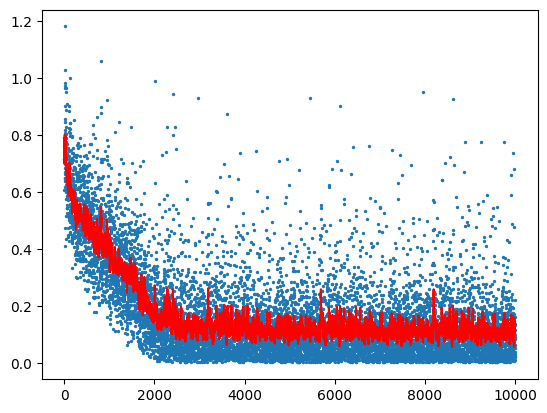

In [62]:
plt.scatter(range(1, 10001), losses, s = [2])
plt.plot(losses_m_avg, c = 'red')

In [61]:
losses_m_avg = []
ema = losses[0]
losses_m_avg.append(ema)
beta = 0.1
for i, loss in enumerate(losses):
    if i == 0:
        continue
    else:
        ema = losses[i] * beta + ema*(1 - beta)
        losses_m_avg.append(ema)

 


In [64]:
ema

<tf.Tensor: shape=(), dtype=float32, numpy=0.10248738>

In [11]:
pred = model(tf.constant(generate_embedding(36010)), shape = (1, 309, 300))

ValueError: Found zero restored functions for caller function.

In [32]:
len(l)

20000

In [39]:
count = 0

In [41]:
for i in tqdm(l[:2500]):
    pred = model(tf.constant(generate_embedding(i), shape = (1, 309, 256)))
    if pred <= 0.5:
        pred = 0
    else:
        pred = 1
    if data_df['classification'][i] == pred:
        count += 1
    

100%|██████████| 2500/2500 [02:36<00:00, 15.97it/s]


In [43]:
count * 100 / 2500

95.52

In [22]:
tf.saved_model.save(model, "../model/model_test_2")

Exception ignored in: <function tqdm.__del__ at 0x7efc552baa60>
Traceback (most recent call last):
  File "/root/miniconda3/envs/mp/lib/python3.9/site-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/root/miniconda3/envs/mp/lib/python3.9/site-packages/tqdm/std.py", line 1291, in close
    if self.last_print_t < self.start_t + self.delay:
AttributeError: 'tqdm' object has no attribute 'last_print_t'


INFO:tensorflow:Assets written to: ../model/model_test_2/assets


INFO:tensorflow:Assets written to: ../model/model_test_2/assets


In [15]:
l.clear()

In [16]:
for i in range(25400, 25500):
    l.append(i)

for i in range(46500, 46550):
    l.append(i)

In [17]:
l

[25400,
 25401,
 25402,
 25403,
 25404,
 25405,
 25406,
 25407,
 25408,
 25409,
 25410,
 25411,
 25412,
 25413,
 25414,
 25415,
 25416,
 25417,
 25418,
 25419,
 25420,
 25421,
 25422,
 25423,
 25424,
 25425,
 25426,
 25427,
 25428,
 25429,
 25430,
 25431,
 25432,
 25433,
 25434,
 25435,
 25436,
 25437,
 25438,
 25439,
 25440,
 25441,
 25442,
 25443,
 25444,
 25445,
 25446,
 25447,
 25448,
 25449,
 25450,
 25451,
 25452,
 25453,
 25454,
 25455,
 25456,
 25457,
 25458,
 25459,
 25460,
 25461,
 25462,
 25463,
 25464,
 25465,
 25466,
 25467,
 25468,
 25469,
 25470,
 25471,
 25472,
 25473,
 25474,
 25475,
 25476,
 25477,
 25478,
 25479,
 25480,
 25481,
 25482,
 25483,
 25484,
 25485,
 25486,
 25487,
 25488,
 25489,
 25490,
 25491,
 25492,
 25493,
 25494,
 25495,
 25496,
 25497,
 25498,
 25499,
 46500,
 46501,
 46502,
 46503,
 46504,
 46505,
 46506,
 46507,
 46508,
 46509,
 46510,
 46511,
 46512,
 46513,
 46514,
 46515,
 46516,
 46517,
 46518,
 46519,
 46520,
 46521,
 46522,
 46523,
 46524,


In [18]:
count2 = 0

In [19]:
for i in tqdm(l):
    pred = model(tf.constant(generate_embedding(i), shape = (1, 309, 300)))
    if pred <= 0.5:
        pred = 0
    else:
        pred = 1
    if data_df['classification'][i] == pred:
        count2 += 1

100%|██████████| 150/150 [01:15<00:00,  1.98it/s]


In [20]:
count2 / len(l)

0.6666666666666666

In [23]:
tf.keras.models.save_model(model, '../data/model_test_2')

INFO:tensorflow:Assets written to: ../data/model_test_2/assets


INFO:tensorflow:Assets written to: ../data/model_test_2/assets


In [ ]:
model.save_weights("../model/model_test_3_weights")

In [27]:
model_loaded = tf.saved_model.load('../data/model_test_2')

In [29]:
pred = model_loaded(tf.constant(generate_embedding(36010), shape = (1, 309, 300)))

ValueError: Found zero restored functions for caller function.